# PREPARE ENVIRONMENT

In [1]:
#Import necessary packages
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
#print version of sklearn package we are using
import sklearn
print(sklearn.__version__)

1.2.2


# DATA PREPROCESSING

Here we will load and process the data such that we can use it to train our model. The output will be a labeled data set consisting of train and test samples.

In [6]:
#Load Calliope generated data
calliope_data = pd.read_excel('/kaggle/input/final-wind-month-data-20-01/surrogate_data_wind_month_cost_final_20_01.xlsx')

print(calliope_data.shape)

#Extract features and output (cost)
X = calliope_data.drop(columns = ["Costs", "Month", "Wind enc"], axis=1)
y = calliope_data['Costs']

print(X.head())
print(y.head())

print(f"Mean of Costs is {np.mean(y)} and Std of Costs is {np.std(y)}")

#use a random plit to create train and test sets
X_train,X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = 42)


(1742, 5)
   Month sin     Month cos
0   0.500000  8.660254e-01
1   0.866025  5.000000e-01
2   1.000000  6.125742e-17
3   0.866025 -5.000000e-01
4   0.500000 -8.660254e-01
0    423466.569651
1    318764.889509
2    216077.817891
3    123852.011335
4    145602.818862
Name: Costs, dtype: float64
Mean of Costs is 157358.11615255798 and Std of Costs is 75282.01838290549


In [7]:
# Scale features
calliope_scaler = StandardScaler()

X_train = calliope_scaler.fit_transform(X_train)

X_test = calliope_scaler.transform(X_test)


# TRAIN MODELS

In this section, will train three different ML models: Linear Regression, Decision Tree and Random Forest. We will start by applying grid search using a train data set. After this configuration, we will evaluate the models using unseen test data. 

In [ ]:
#Set up parameter grid for each ML model
#We do not perform grid search on the Linear Regression Model,
#since there are no hyperparameters to tune

param_grid_dt = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10,20,50],
}

param_grid_rf = {
    'n_estimators': [50, 100, 200,500],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [5,10, 20,50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [10, 20, 50]
}


In [ ]:
#Set up GridSearchCV for the models
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, scoring='neg_mean_absolute_error', cv=5)

dt = DecisionTreeRegressor(random_state=42)
grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt,scoring='neg_mean_absolute_error', cv=5)

# Fit the models using the training data set
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_

grid_search_dt.fit(X_train, y_train)
best_params_dt = grid_search_dt.best_params_

# Print results of the hypertuning
print("Best parameters for Decision Tree:", best_params_dt)
print("Best parameters for Random Forest:", best_params_rf)



In [8]:
#Define best ML models - according to the hypertuning
#Only use if grid search has been performed
# rf_model = grid_search_rf.best_estimator_
# dt_model = grid_search_dt.best_estimator_

#Define Linear Regression Model
lr_model = LinearRegression()

#Define DecisionTree and RandomForest Model - only use if gridsearch has not been performed
rf_model = RandomForestRegressor(random_state = 42)
dt_model = DecisionTreeRegressor(random_state=42)

# EVALUATE MODELS

We start by defining a function to evaluate the ML models. The intrinsic metric has been set to be the Mean Absolute Error.

In [9]:
def evaluate_model(ML_model):
    #Fit model
    ML_model.fit(X_train, y_train)
    
    #Predict the costs
    y_train_pred = ML_model.predict(X_train)
    y_test_pred = ML_model.predict(X_test)
    
    #calculate MAE (intrinsic accuracy metric)
    train_mae = mean_absolute_error(y_train_pred, y_train)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    return y_test_pred,np.mean(train_mae),np.mean(test_mae)

Now we will apply these functions on the ML models.

In [10]:
#Evaluate ML Models
lr_test_pred, lr_train_mae, lr_test_mae = evaluate_model(lr_model)
dt_test_pred, dt_train_mae, dt_test_mae = evaluate_model(dt_model)
rf_test_pred, rf_train_mae, rf_test_mae = evaluate_model(rf_model)

print("Final MAE train data LR:", lr_train_mae)
print("Final MAE test data  LR:", lr_test_mae)
print("Final MAE train data DT:", dt_train_mae)
print("Final MAE test data  DT:", dt_test_mae)
print("Final MAE train data RF:", rf_train_mae)
print("Final MAE test data  RF:", rf_test_mae)

Final MAE train data LR: 34935.28489055479
Final MAE test data  LR: 39832.564259473154
Final MAE train data DT: 31986.53256529036
Final MAE test data  DT: 37687.49484274872
Final MAE train data RF: 32015.789617775758
Final MAE test data  RF: 37689.006531548686


Here we apply a seasonal metric (different weights for different months, where winter months are being weighted more heavily) to obtain a MAE that takes importance of the seasons into account. During winter, it is deemed more important to have accurate performance.

In [13]:
def evaluate_model_weighted(ML_model, X_train, y_train, X_test, y_test, scaler_X):
    # Fit model
    ML_model.fit(X_train, y_train)
    
    # Predict the costs
    y_train_pred = ML_model.predict(X_train)
    y_test_pred = ML_model.predict(X_test)
    
    # Calculate MAE (intrinsic accuracy metric)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Inverse transform test data to original scale for month extraction
    X_test_orig = scaler_X.inverse_transform(X_test)
    sin_month = X_test_orig[:, 0]
    cos_month = X_test_orig[:, 1]
    months = np.round((np.arctan2(sin_month, cos_month) / (2 * np.pi)) * 12 + 1) % 12 + 1
    
    # Define month weights
    month_weights = {
        1: 2,   
        2: 1.8,  
        3: 1.6, 
        4: 1.4, 
        5: 1.2, 
        6: 1.0, 
        7: 1.0, 
        8: 1.2, 
        9: 1.4, 
        10: 1.6, 
        11: 1.8,  
        12: 2 
    }
    
    # Calculate weighted MAE
    weighted_mae = 0
    total_weight = 0
    for i in range(len(y_test)):
        month = int(months[i])  # Convert to integer month
        weight = month_weights[month]
        error = abs(y_test.iloc[i] - y_test_pred[i])
        weighted_mae += weight * error
        total_weight += weight
    
    weighted_mae /= total_weight  # Normalize by total weight
    
    # Return evaluation results
    return abs(y_test - y_test_pred).mean(), weighted_mae


In [14]:
lr_normal_mae, lr_weighted_mae = evaluate_model_weighted(lr_model,X_train,y_train,X_test,y_test,calliope_scaler)
dt_normal_mae, dt_weighted_mae = evaluate_model_weighted(dt_model,X_train,y_train,X_test,y_test,calliope_scaler)
rf_normal_mae, rf_weighted_mae = evaluate_model_weighted(rf_model,X_train,y_train,X_test,y_test,calliope_scaler)

print("LR: normal mae", lr_normal_mae, "weighted mae", lr_weighted_mae)
print("DT: normal mae", dt_normal_mae, "weighted mae", dt_weighted_mae)
print("RF: normal mae", rf_normal_mae, "weighted mae", rf_weighted_mae)

LR: normal mae 39832.564259473154 weighted mae 42406.04418569033
DT: normal mae 37687.49484274872 weighted mae 40013.915026249335
RF: normal mae 37689.006531548686 weighted mae 39997.072247246324


# Visualise Result Months vs Cost

In [18]:
# Compute the month from sine and cosine values
def compute_month(sin_values, cos_values):
    angles = np.arctan2(sin_values, cos_values)  # Calculate angle in radians
    months = (np.round((angles % (2 * np.pi)) / (2 * np.pi) * 12) + 1).astype(int)  # Map angle to month (1-12)
    return months

# Calculate months
sin_values = X_test[:, 0]
cos_values = X_test[:, 1]
months = compute_month(sin_values, cos_values)

# Create a DataFrame
data = pd.DataFrame({
    'month': months,
    'sine': sin_values,
    'cosine': cos_values,
    'predicted_cost': rf_test_pred,
    'actual_cost': y_test
})

# Group data by month
grouped_data = data.groupby('month')

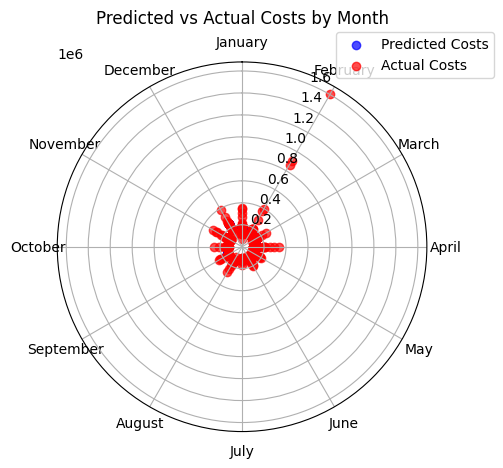

In [19]:
def plot_circular_months_costs(grouped_data):
    """
    Plots predicted and actual costs for grouped data (pandas DataFrame) on a circular plot with month names outside the circle.

    Args:
        grouped_data (pandas.DataFrameGroupBy): Data grouped by month.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']

    # Prepare the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Scatter plot data
    predicted_angles = []
    predicted_costs = []
    actual_angles = []
    actual_costs = []

    # Loop through each month in the grouped data
    for month, group in grouped_data:
        # Calculate the angle for the month (theta = 2π * (month - 1) / 12)
        angle = 2 * np.pi * (month - 1) / 12

        # Add predicted and actual costs to the respective lists
        predicted_angles.extend([angle] * len(group))
        predicted_costs.extend(group['predicted_cost'])
        actual_angles.extend([angle] * len(group))
        actual_costs.extend(group['actual_cost'])

    # Scatter plot for predicted costs
    ax.scatter(predicted_angles, predicted_costs, c='blue', label='Predicted Costs', alpha=0.7)

    # Scatter plot for actual costs
    ax.scatter(actual_angles, actual_costs, c='red', label='Actual Costs', alpha=0.7)

    # Add radial grid with month names
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Predicted vs Actual Costs by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("circular_month_vs_cost_all.png", format='png', dpi=300)
    plt.show()

# Call the plotting function
plot_circular_months_costs(grouped_data)

In [20]:
#Now we aggregate the data to look at the avg costs per month

# Compute the month from sine and cosine values
def compute_month(sin_values, cos_values):
    angles = np.arctan2(sin_values, cos_values)  # Calculate angle in radians
    months = (np.round((angles % (2 * np.pi)) / (2 * np.pi) * 12) + 1).astype(int)  # Map angle to month (1-12)
    return months

# Create a DataFrame
sin_values = X_test[:, 0]  # Sine values
cos_values = X_test[:, 1]  # Cosine values
months = compute_month(sin_values, cos_values)

data = pd.DataFrame({
    'month': months,
    'predicted_cost': rf_test_pred,
    'actual_cost': y_test
})

# Aggregate by month
aggregated_data = data.groupby('month').agg({
    'predicted_cost': 'mean',
    'actual_cost': 'mean'
}).reset_index()

# Add radial angle for plotting
aggregated_data['angle'] = 2 * np.pi * (aggregated_data['month'] - 1) / 12


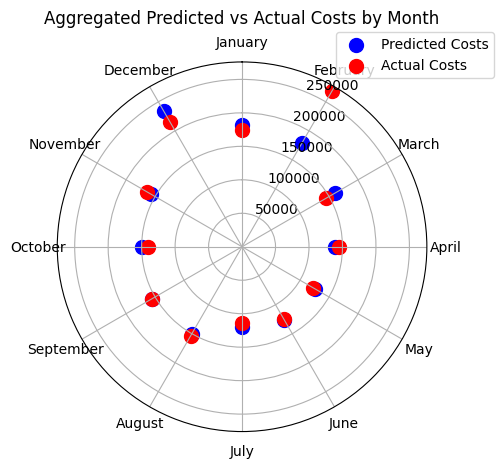

In [21]:
def plot_aggregated_circular_month_costs(aggregated_data):
    """
    Plots aggregated predicted and actual costs by month on a circular plot with month names as labels.
    
    Args:
        aggregated_data (pd.DataFrame): Aggregated data containing 'month', 'predicted_cost', 'actual_cost', and 'angle'.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Plot predicted costs
    ax.scatter(aggregated_data['angle'], aggregated_data['predicted_cost'], 
               c='blue', label='Predicted Costs', s=100)

    # Plot actual costs
    ax.scatter(aggregated_data['angle'], aggregated_data['actual_cost'], 
               c='red', label='Actual Costs', s=100)

    # Add radial grid with month names instead of numeric angles
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Aggregated Predicted vs Actual Costs by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("circular_month_vs_cost_wind_aggregated.png", format='png', dpi=300)
    plt.show()

# Plot aggregated data with month names
plot_aggregated_circular_month_costs(aggregated_data)

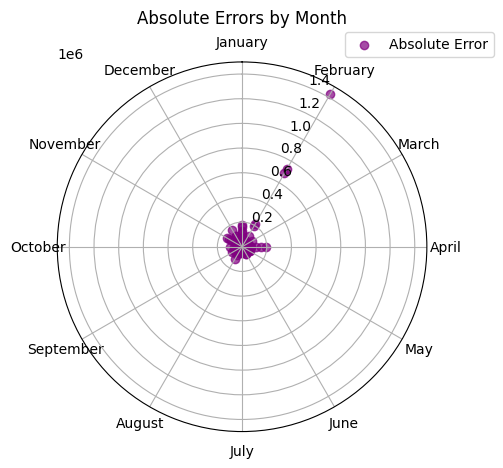

In [22]:
def plot_absolute_errors_grouped_by_month(grouped_data):
    """
    Plots the absolute errors for grouped data (pandas DataFrame) on a circular plot with month names outside the circle.

    Args:
        grouped_data (pandas.DataFrameGroupBy): Data grouped by month.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']

    # Prepare the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Data for absolute errors
    angles = []
    absolute_errors = []

    # Loop through each month in the grouped data
    for month, group in grouped_data:
        # Calculate the angle for the month (theta = 2π * (month - 1) / 12)
        angle = 2 * np.pi * (month - 1) / 12

        # Compute absolute errors
        abs_error = (group['predicted_cost'] - group['actual_cost']).abs()

        # Add to the lists for plotting
        angles.extend([angle] * len(abs_error))
        absolute_errors.extend(abs_error)

    # Scatter plot for absolute errors
    scatter = ax.scatter(angles, absolute_errors, c='purple', label='Absolute Error', alpha=0.7)

    # Add radial grid with month names
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Absolute Errors by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("circular_month_vs_cost_wind_absolute_error.png", format='png', dpi=300)
    # Show the plot
    plt.show()


# Call the updated function
plot_absolute_errors_grouped_by_month(grouped_data)

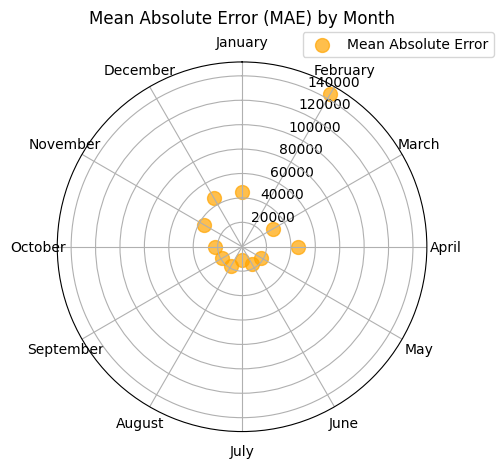

In [23]:
def plot_mean_absolute_error_grouped_by_month(grouped_data):
    """
    Plots the mean absolute error (MAE) for grouped data (pandas DataFrame) on a circular plot with month names outside the circle.

    Args:
        grouped_data (pandas.DataFrameGroupBy): Data grouped by month.
    """
    # Month names
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']

    # Prepare the plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.set_theta_zero_location('N')  # Set zero to the top (North)
    ax.set_theta_direction(-1)  # Set direction clockwise

    # Data for mean absolute errors
    angles = []
    mean_absolute_errors = []

    # Loop through each month in the grouped data
    for month, group in grouped_data:
        # Calculate the angle for the month (theta = 2π * (month - 1) / 12)
        angle = 2 * np.pi * (month - 1) / 12

        # Compute the mean absolute error for the month
        mae = (group['predicted_cost'] - group['actual_cost']).abs().mean()

        # Add to the lists for plotting
        angles.append(angle)
        mean_absolute_errors.append(mae)

    # Scatter plot for mean absolute errors
    ax.scatter(angles, mean_absolute_errors, c='orange', label='Mean Absolute Error', alpha=0.7, s=100)

    # Add radial grid with month names
    ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
    ax.set_xticklabels(month_names, fontsize=10)

    # Add title, legend, and grid
    ax.set_title("Mean Absolute Error (MAE) by Month", va='bottom')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    ax.grid(True)
    plt.savefig("circular_month_vs_cost_wind_mae.png", format='png', dpi=300)
    # Show the plot
    plt.show()

# Call the function
plot_mean_absolute_error_grouped_by_month(grouped_data)